# Sentiment analysis project 

Imports:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

import csv
import re

Read the data:

In [9]:
df_original = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')
df_original.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Pre processing:

In [19]:
# Pick only relevant data:
df = df_original[['Score','Text']]

# remove text inside '< >':
texts = df.get(['Text']).values
texts_revised = []
for row in texts:
    tmp = re.sub(r'<.+?>', ' ', str(row))
    tmp = tmp.lower()
    texts_revised.append(tmp)
df['Text'] = texts_revised.copy()
df.head()


/Users/lisasjoblom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Score,Text
0,5,['i have bought several of the vitality canned...
1,1,['product arrived labeled as jumbo salted pean...
2,4,['this is a confection that has been around a ...
3,2,['if you are looking for the secret ingredient...
4,5,['great taffy at a great price. there was a w...


Small analyze of data:

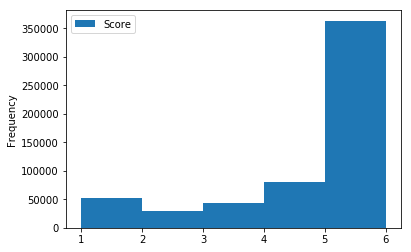

There are 246927397 words in the combination of all reviews.


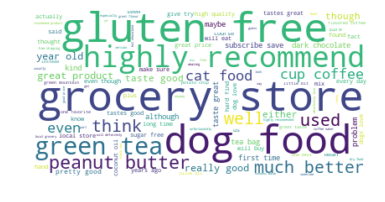

In [22]:
###### SCORE DISTRIBUTION ######
df.plot.hist(bins=[1, 2, 3, 4, 5, 6])
plt.show()

###### WORDCLOUD #######
text = " ".join(review for review in df.Text)
print ("There are {} words in the combination of all reviews.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#wordcloud.to_file("img/first_review.png")

Define first RNN model: